# 01_exploration_donnees.ipynb

Notebook d'exploration du dataset Covid19-dataset

**Objectifs:**
- Lister les classes et compter le nombre d'images par classe
- Identifier les déséquilibres
- Calculer la résolution moyenne, formats, tailles de fichiers
- Visualiser des exemples d'images par classe
- Générer des histogrammes et statistiques descriptives

In [1]:
# Imports
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Ajouter le chemin racine au PYTHONPATH pour importer src
sys.path.append('..')

from src.data_processing import (
    gather_image_paths,
    get_class_distribution,
    compute_image_statistics,
    summarize_image_stats,
    save_summary_csv,
)

%matplotlib inline
sns.set_style('whitegrid')

# Définir le chemin vers le dataset (raw)
RAW_ROOT = "../data/raw/Covid19-dataset"

print("✓ Imports réussis")

✓ Imports réussis


## 1. Récupération des chemins d'images par classe

In [2]:
# Récupérer les chemins des images organisés par classe
paths_dict = gather_image_paths(RAW_ROOT)

print(f"Nombre de classes détectées: {len(paths_dict)}")
print(f"\nClasses: {list(paths_dict.keys())}")

# Distribution des images par classe
dist_df = get_class_distribution(paths_dict)
print("\n📊 Distribution des images par classe:")
dist_df

Nombre de classes détectées: 2

Classes: ['test', 'train']

📊 Distribution des images par classe:


,class,n_images
0,train,251
1,test,66


## 2. Visualisation de la distribution des classes

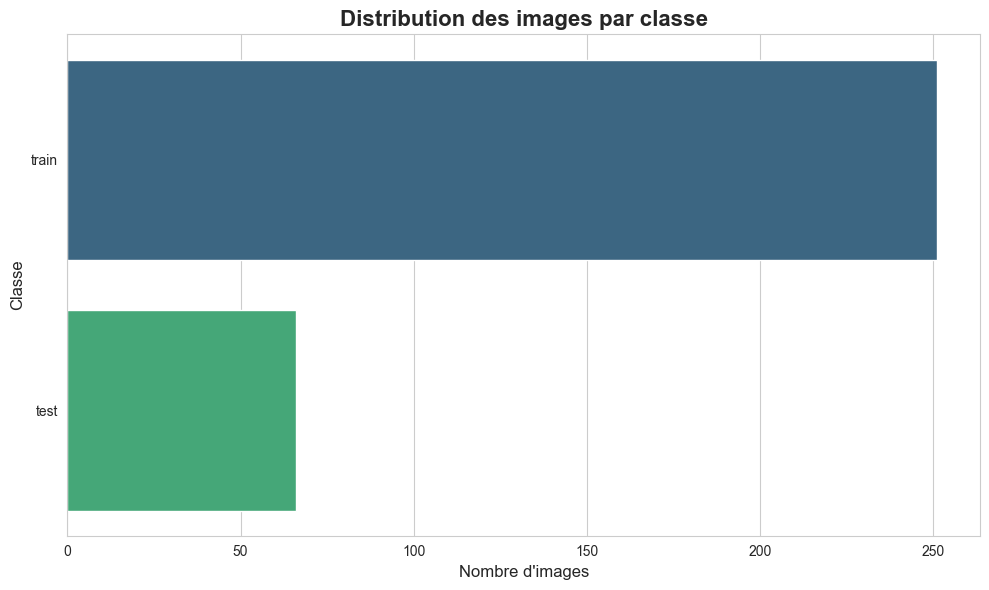


⚠️ Déséquilibre détecté:
   - Classe avec le plus d'images: 251
   - Classe avec le moins d'images: 66
   - Ratio max/min: 3.80


In [3]:
# Visualiser la distribution des classes
plt.figure(figsize=(10, 6))
sns.barplot(data=dist_df, x='n_images', y='class', palette='viridis')
plt.title('Distribution des images par classe', fontsize=16, fontweight='bold')
plt.xlabel('Nombre d\'images', fontsize=12)
plt.ylabel('Classe', fontsize=12)
plt.tight_layout()
plt.savefig('../results/figures/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Identifier le déséquilibre
max_images = dist_df['n_images'].max()
min_images = dist_df['n_images'].min()
ratio = max_images / min_images if min_images > 0 else float('inf')
print(f"\n⚠️ Déséquilibre détecté:")
print(f"   - Classe avec le plus d'images: {max_images}")
print(f"   - Classe avec le moins d'images: {min_images}")
print(f"   - Ratio max/min: {ratio:.2f}")

## 3. Statistiques sur les images (résolution, format, taille)

In [4]:
# Calculer les statistiques d'images (résolution, format, taille)
print("⏳ Calcul des statistiques sur toutes les images (peut prendre quelques minutes)...")
all_paths = [p for lst in paths_dict.values() for p in lst]
print(f"Nombre total d'images: {len(all_paths)}")

stats_df = compute_image_statistics(all_paths)
summary = summarize_image_stats(stats_df)

print('\n📏 Statistiques numériques (résolution, taille):')
display(summary['numeric_stats'])

print('\n📁 Distribution des formats:')
display(summary['format_counts'])

⏳ Calcul des statistiques sur toutes les images (peut prendre quelques minutes)...
Nombre total d'images: 317

📏 Statistiques numériques (résolution, taille):


,count,mean,median,min,max
width,317.0,1624.583596,1582.0,416.0,4248.0
height,317.0,1352.927445,1319.0,341.0,4095.0
file_size,317.0,535148.331230,349654.0,30930.0,6118180.0



📁 Distribution des formats:


,format,count
0,JPEG,306
1,PNG,11


## 4. Histogrammes des résolutions et tailles

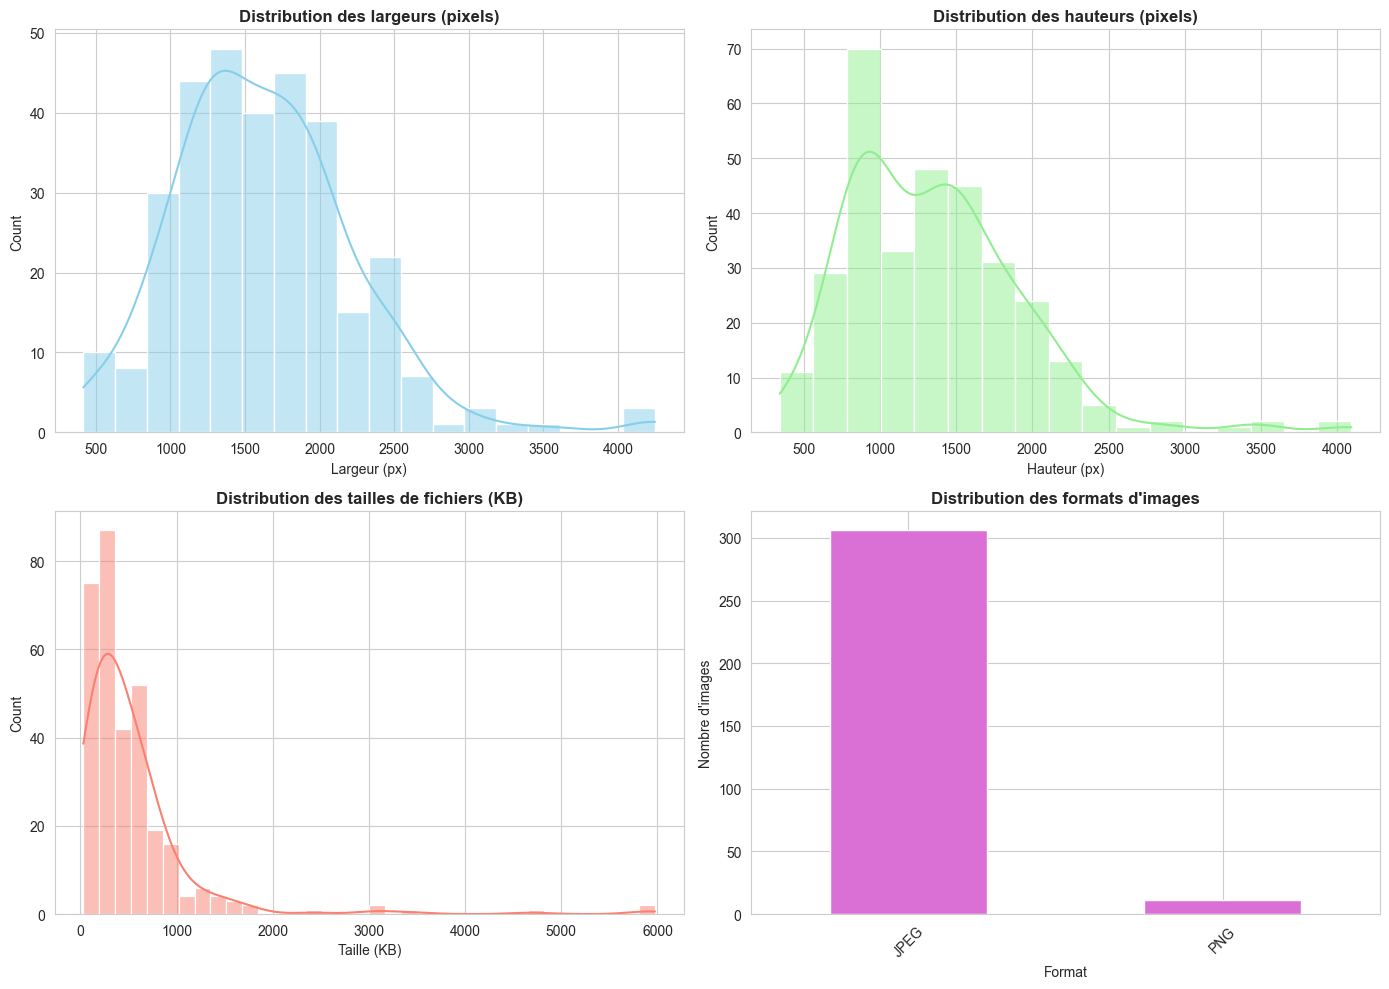

In [5]:
# Histogrammes des résolutions et tailles
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Largeur
sns.histplot(stats_df['width'].dropna(), kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribution des largeurs (pixels)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Largeur (px)')

# Hauteur
sns.histplot(stats_df['height'].dropna(), kde=True, color='lightgreen', ax=axes[0, 1])
axes[0, 1].set_title('Distribution des hauteurs (pixels)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Hauteur (px)')

# Taille fichier en KB
sns.histplot(stats_df['file_size'].dropna() / 1024, kde=True, color='salmon', ax=axes[1, 0])
axes[1, 0].set_title('Distribution des tailles de fichiers (KB)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Taille (KB)')

# Format (barplot)
format_counts = stats_df['format'].value_counts()
format_counts.plot(kind='bar', color='orchid', ax=axes[1, 1])
axes[1, 1].set_title('Distribution des formats d\'images', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Format')
axes[1, 1].set_ylabel('Nombre d\'images')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/figures/image_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Visualisation d'exemples d'images par classe

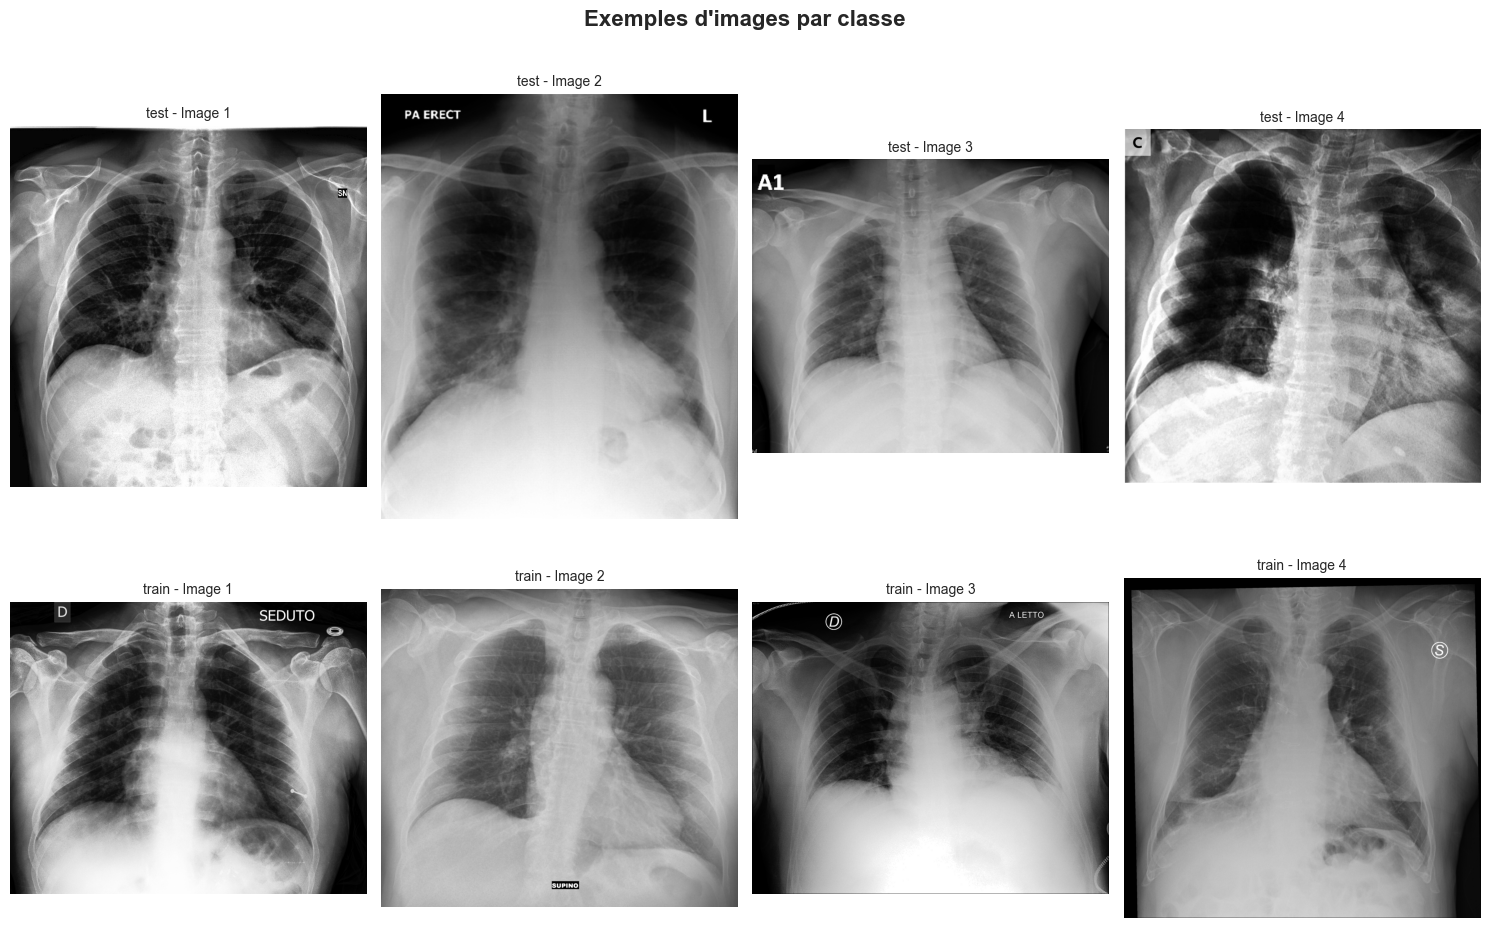

In [6]:
# Afficher des exemples d'images par classe
def show_samples_by_class(paths_dict, n_per_class=3, figsize=(15, 10)):
    """
    Affiche n_per_class exemples pour chaque classe
    """
    classes = list(paths_dict.keys())
    n_classes = len(classes)
    
    fig, axes = plt.subplots(n_classes, n_per_class, figsize=figsize)
    
    # Si une seule classe, axes n'est pas un array 2D
    if n_classes == 1:
        axes = axes.reshape(1, -1)
    
    for i, cls in enumerate(classes):
        for j in range(n_per_class):
            if j < len(paths_dict[cls]):
                img_path = paths_dict[cls][j]
                try:
                    img = Image.open(img_path).convert('RGB')
                    axes[i, j].imshow(img)
                    axes[i, j].set_title(f"{cls} - Image {j+1}", fontsize=10)
                except Exception as e:
                    axes[i, j].text(0.5, 0.5, f'Erreur\n{str(e)[:20]}', 
                                   ha='center', va='center')
            axes[i, j].axis('off')
    
    plt.suptitle('Exemples d\'images par classe', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('../results/figures/sample_images_by_class.png', dpi=300, bbox_inches='tight')
    plt.show()

show_samples_by_class(paths_dict, n_per_class=4)

## 6. Sauvegarde des résultats d'exploration

In [8]:
# Sauvegarder les résultats d'exploration
os.makedirs('../results/metrics', exist_ok=True)
os.makedirs('../results/figures', exist_ok=True)

# Sauvegarder la distribution
save_summary_csv(dist_df, out_path='../results/metrics/data_distribution.csv')

# Sauvegarder les statistiques détaillées
stats_df.to_csv('../results/metrics/image_stats_detailed.csv', index=False)

# Sauvegarder les statistiques résumées
summary['numeric_stats'].to_csv('../results/metrics/image_stats_summary.csv')
summary['format_counts'].to_csv('../results/metrics/format_distribution.csv', index=False)

print('✓ Fichiers sauvegardés dans results/metrics/')
print('✓ Visualisations sauvegardées dans results/figures/')

✓ Fichiers sauvegardés dans results/metrics/
✓ Visualisations sauvegardées dans results/figures/


## 7. Observations et Remarques

**À compléter après exécution:**

### Déséquilibre des classes:
- [ ] Y a-t-il un déséquilibre important entre les classes?
- [ ] Quelle stratégie adopter? (class weights, SMOTE, augmentation ciblée)

### Qualité des images:
- [ ] Les résolutions sont-elles homogènes?
- [ ] Y a-t-il des images corrompues?
- [ ] Tous les formats sont-ils supportés?

### Préparation pour le preprocessing:
- [ ] Quelle taille cible choisir? (224x224 pour EfficientNet-B0)
- [ ] Quelle stratégie d'augmentation adopter?
- [ ] Faut-il nettoyer certaines images?

### Actions à prendre:
1. ...
2. ...
3. ...